<a href="https://colab.research.google.com/github/USCbiostats/PM520/blob/main/Lab_12_MCMC_BlackJAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install blackjax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 12.1 MB/s eta 0:00:00


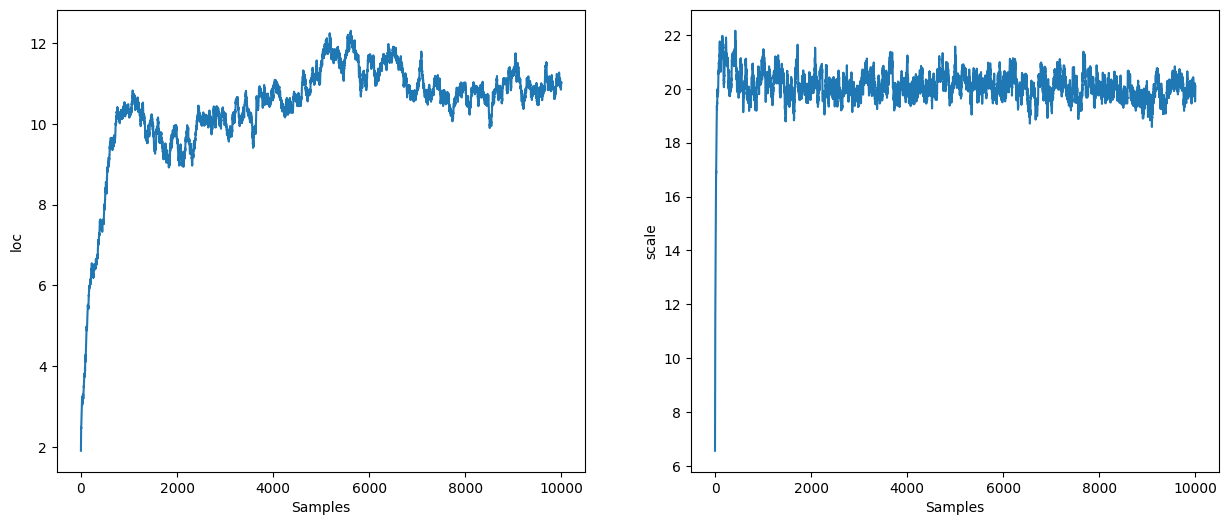

In [3]:
# warm up
import matplotlib.pyplot as plt
import numpy as np

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats

import blackjax


seed = 0
rng_key = jax.random.key(seed)

# true values that generate our observations
loc, scale = 10, 20
observed = np.random.normal(loc, scale, size=1_000)


# set up our density function
def logdensity_fn(loc, log_scale, observed=observed):
    """Univariate Normal"""
    scale = jnp.exp(log_scale)
    logpdf = stats.norm.logpdf(observed, loc, scale)
    return jnp.sum(logpdf)


def logdensity(x):
  return logdensity_fn(**x)


# kernel params
inv_mass_matrix = np.array([0.5, 0.01])
num_integration_steps = 60
step_size = 1e-3

# set up our kernel
hmc = blackjax.hmc(logdensity, step_size, inv_mass_matrix, num_integration_steps)

# sample from posterior
rng_key, sample_key = jax.random.split(rng_key)

initial_position = {"loc": 1.0, "log_scale": 1.0}
initial_state = hmc.init(initial_position)
hmc_kernel = jax.jit(hmc.step)


def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

states = inference_loop(sample_key, hmc_kernel, initial_state, 10_000)

mcmc_samples = states.position
mcmc_samples["scale"] = jnp.exp(mcmc_samples["log_scale"]).block_until_ready()

# visualize results
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(15, 6))
ax.plot(mcmc_samples["loc"])
ax.set_xlabel("Samples")
ax.set_ylabel("loc")

ax1.plot(mcmc_samples["scale"])
ax1.set_xlabel("Samples")
ax1.set_ylabel("scale");

## Bayesian Logistic Regression, revisited

In [ ]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import blackjax

from sklearn.datasets import make_biclusters


plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["figure.figsize"] = (12, 8)

seed = 0
rng_key = jax.random.key(seed)

# generate data
num_points = 50
X, rows, cols = make_biclusters(
    (num_points, 2), 2, noise=0.6, random_state=314, minval=-3, maxval=3
)
y = rows[0] * 1.0  # y[i] = whether point i belongs to cluster 1

# visualize data/labels
colors = ["tab:red" if el else "tab:blue" for el in rows[0]]
plt.scatter(*X.T, edgecolors=colors, c="none")
plt.xlabel(r"$X_0$")
plt.ylabel(r"$X_1$");

In [ ]:
# set up likelihoods

Phi = jnp.c_[jnp.ones(num_points)[:, None], X]
N, M = Phi.shape


def sigmoid(z):
    return jnp.exp(z) / (1 + jnp.exp(z))


def log_sigmoid(z):
    return z - jnp.log(1 + jnp.exp(z))


def logdensity_fn(w, alpha=1.0):
    """The log-probability density function of the posterior distribution of the model."""
    log_an = log_sigmoid(Phi @ w)
    an = Phi @ w
    log_likelihood_term = y * log_an + (1 - y) * jnp.log(1 - sigmoid(an))
    prior_term = alpha * w @ w / 2

    return -prior_term + log_likelihood_term.sum()


# sample initial weights, w
rng_key, init_key = jax.random.split(rng_key)

w0 = jax.random.multivariate_normal(init_key, 0.1 + jnp.zeros(M), jnp.eye(M))
rmh = blackjax.rmh(logdensity_fn, blackjax.mcmc.random_walk.normal(jnp.ones(M) * 0.05))
initial_state = rmh.init(w0)

# set up inference loop
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

# perform inference and sample
rng_key, sample_key = jax.random.split(rng_key)
states = inference_loop(sample_key, rmh.step, initial_state, 5_000)

In [ ]:
burnin = 300

fig, ax = plt.subplots(1, 3, figsize=(12, 2))
for i, axi in enumerate(ax):
    axi.plot(states.position[:, i])
    axi.set_title(f"$w_{i}$")
    axi.axvline(x=burnin, c="tab:red")
plt.show()